Bryan Jay - 260738764
### 2.2 Epipolar Geometry
SIFT POINTS

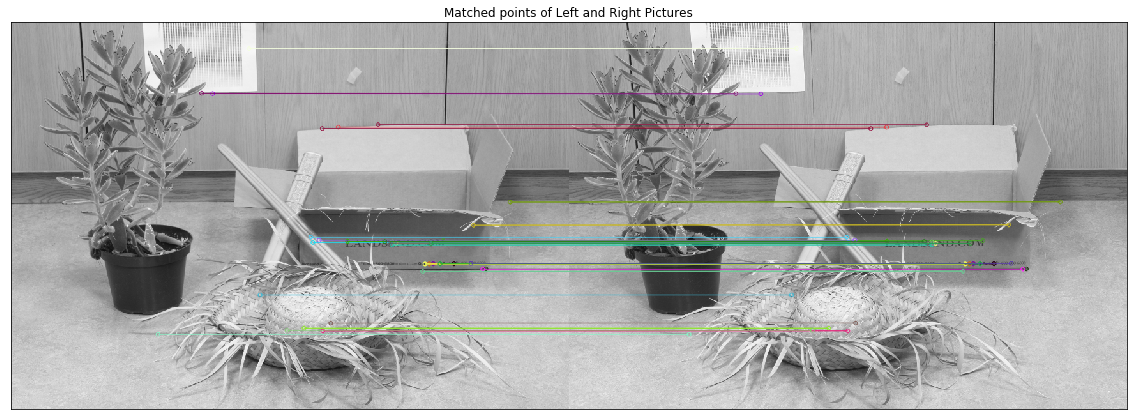

In [134]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

# # load left and right images
# imgR = cv2.imread("umbrella0.png")
# imgL = cv2.imread("umbrella1.png")

# # convert the images to colour RGB 
# imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
# imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# # copy the image
# imgL_dsp = imgL.copy()
# imgR_dsp = imgR.copy()

# # create a sift object 
# sift = cv2.xfeatures2d.SIFT_create()

# load left and right images
imgL = cv2.imread("swords0.png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("swords1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# copy the image
imgL_dsp = imgL.copy()
imgR_dsp = imgR.copy()

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
keypoints_imgL, descriptors_imgL = sift.detectAndCompute(imgL, None)
keypoints_imgR, descriptors_imgR = sift.detectAndCompute(imgR, None)


# draw the keypoints 
cv2.drawKeypoints(imgL, keypoints_imgL, imgL_dsp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgR, keypoints_imgR, imgR_dsp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Create a BFMatcher object and match the descriptors 
bf = cv2.BFMatcher()
matches = bf.match(descriptors_imgL,descriptors_imgR)

# Sort them by distance and draw all the matches
matches = sorted(matches, key=lambda match:match.distance)
matched_image12 = cv2.drawMatches(imgL, keypoints_imgL, imgR, keypoints_imgR, matches[:40], imgL, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(matched_image12)
plt.title('Matched points of Left and Right Pictures'), plt.xticks([]), plt.yticks([])
plt.show()


Finding Epipolar Lines

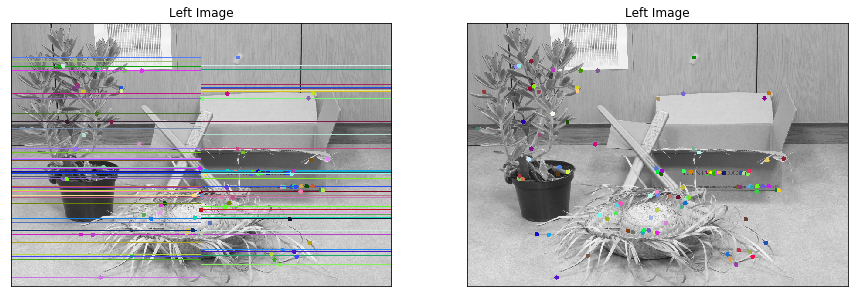

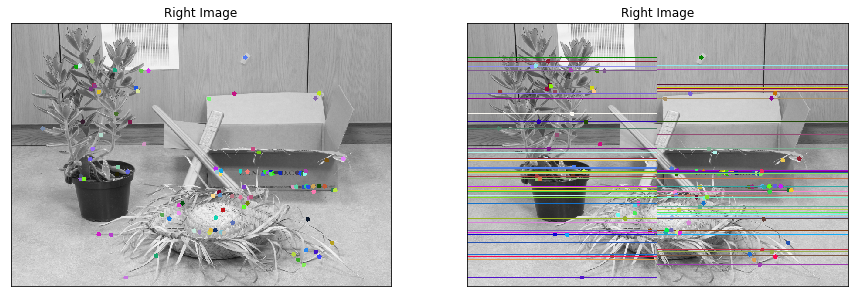

In [162]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgR = cv2.imread("swords0.png", cv2.IMREAD_GRAYSCALE)
imgL = cv2.imread("swords1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.4 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Picked any keypoint in the right image without a match in the left image

[(785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7018280029297), (785.281494140625, 229.7

C:\ProgramData\Anaconda3\Lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


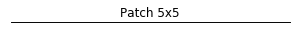

In [163]:
ptsL_bad = []
ptsR_bad = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.9 * n.distance:
        ptsR_bad.append(kpR[m.trainIdx].pt)
        ptsL_bad.append(kpL[m.queryIdx].pt)

for


# find the coordinates for all non matching points 
mismatchListL = [kpL[m.queryIdx].pt for pointL in kpL if pointL not in ptsL]
mismatchListR = [kpR[m.trainIdx].pt for pointR in kpR if pointR not in ptsR]

# checked if any points are on the epipolar lines
fin_mismatch = list()
for i in range(len(mismatchListR)):
    for j in range(len(linesR)):
        y = -1*(linesR[j][0]*mismatchListR[i][0] + linesR[j][2])/linesR[j][1]
        if(int(y) != mismatchListR[i][1] and mismatchListR[i] not in fin_mismatch):
            fin_mismatch.append(mismatchListR[i])
print(mismatchListR)
print("Non-Matching Keypoint: ", fin_mismatch)
nonKeypt = (int(fin_mismatch[0][0]), int(fin_mismatch[0][1]))
print("Non-Matching Keypoint: ", nonKeypt)

print(imgR.shape)
# get 5x5 patch by taking the top 3 and bottom 2 pixels and timilarly for the side
patch = imgR[nonKeypt[0]-3:nonKeypt[0]+2,nonKeypt[1]-3:nonKeypt[1]+2]

# display patch 
plt.figure(figsize=(5,5))
plt.subplot(111), plt.imshow(patch, cmap="gray")
plt.title("Patch 5x5"), plt.xticks([]), plt.yticks([])
plt.show()
    
# patch_center = numpy.array([500, 450])1#  smaller_dim = numpy.min(image.shape[0:2])
# patch_scale = 0.23
# patch_size = patch_scale * smaller_dim
# patch_x = patch_center[0] - patch_size/2
# patch_y = patch_center[1] - patch_size/2
# patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
    

#### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one

#### Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?

#### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?